Problem 4.

In [1]:
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

np.set_printoptions(precision=4, suppress=True)

import matplotlib.pyplot as plt

Problem 4.b.

(100, 10)
(100, 1)
0.5


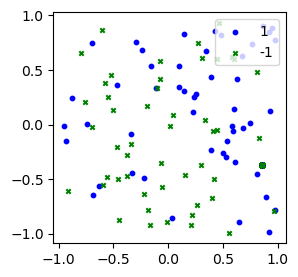

In [2]:
def logistic_fn(x, y, w):
    return 1/(1 + np.exp(-y*np.matmul(w,x.T)))

def logistic_loss(x, y, w):
    return np.log(1 + np.exp(-y*np.matmul(w,x.T)))

def logistic_grad(x, y, w):
    # logit = logistic_fn(x, y, w)
    tmp = np.exp(-y*np.matmul(w,x.T))/(1 + np.exp(-y*np.matmul(w,x.T)))
    return -tmp*y*x

def generate_data(num_samples, num_feats, u_true, seed=12345):
    X_train = []
    y_train = []
    cnt = 0
    
    np.random.seed(seed)
    uniform_dist = stats.uniform(loc=-1, scale=2)
    while cnt < num_samples:
        x_i = uniform_dist.rvs(size=(1,num_feats))
        logit = logistic_fn(x_i, 1, u_true)[0,0]
        # print(logit)
        y_i = 1 if logit >= np.random.uniform(low=0, high=1) else -1
        X_train.append(x_i)
        y_train.append(y_i)
        cnt += 1

    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    # print(X_train[:10])
    # print(X_train.shape)
    # print(y_train.shape)
    return X_train, y_train
    
# parameters
num_samples = 100
num_feats = 10
u_true = 2*np.ones((1,num_feats))/np.sqrt(num_feats) 

# generate data
X_train, y_train = generate_data(num_samples, num_feats, u_true, seed=12345) 
print(X_train.shape)
print(y_train.shape)

# plot

ypos_idxes = np.where(y_train >= 0)
yneg_idxes = np.where(y_train < 0)
num_ypos = np.sum(y_train >= 0)
num_yneg = np.sum(y_train < 0)
print(np.sum(y_train>=0)/num_samples)

fig, axes = plt.subplots(1, 1, figsize=(3,3))
axes = [axes]
axes[0].scatter(X_train[ypos_idxes,0], X_train[ypos_idxes,1], color="blue", label=1, s=10, marker="o")
axes[0].scatter(X_train[yneg_idxes,0], X_train[yneg_idxes,1], color="green", label=-1, s=10, marker="x")
axes[0].legend(loc="upper right")
plt.show()

Best c = 3.00000, step_size = 0.30000


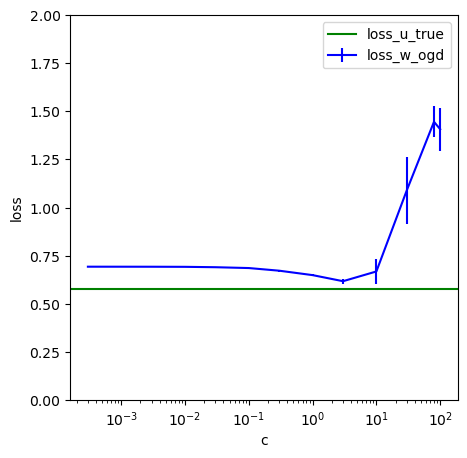

In [3]:
def compute_l2norm(w):
    return np.sqrt(np.sum(w**2))

def project_weight(w, threshold):
    w_norm = compute_l2norm(w)
    if w_norm > threshold:
        w = threshold * w/w_norm
    return w

def train_ogd(X, y, step_size, w_norm_threshold):
    num_samples, num_feats = X.shape
    
    w_array = np.zeros((num_samples, num_feats))
    w_t = np.zeros((1, num_feats))
    for t in range(num_samples):
        w_array[t] = w_t
        
        # get x_t, y_t
        x_t = X[t,:]
        y_t = y[t,:]
        
        # compute grad
        grad = logistic_grad(x_t, y_t, w_t)
        
        # update w
        w_t = w_t - step_size*grad
  
        tmp = compute_l2norm(w_t)
        w_t = project_weight(w_t, w_norm_threshold)
          
    w_ogd = np.average(w_array, axis=0)
    return w_ogd

def compute_loss(X, y, w):
    num_samples, num_feats = X.shape
    
    loss_total = 0
    for i in range(num_samples):
        loss_total += logistic_loss(X[i,:], y[i,:], w)[0]
        
    return loss_total/num_samples
  
# parameters 
num_feats = 10
nsamples_train = 100
nsamples_test = 500

u_true = 2*np.ones((1,num_feats))/np.sqrt(num_feats)
w_norm_threshold = 20

num_runs = 5 
c_list = [0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 80, 100]
loss_w_ogd_array = np.zeros((len(c_list), num_runs))
loss_u_true_array = np.zeros((len(c_list), num_runs))
for cidx, c in enumerate(c_list):
    # print(f"\n-> idx = {cidx}, c = {c}")
    for ridx in range(num_runs):
        X_train, y_train = generate_data(nsamples_train, num_feats, u_true, seed=10000+100*cidx+ridx) 
        X_test, y_test = generate_data(nsamples_test, num_feats, u_true, seed=20000+100*cidx+ridx)

        step_size = c/np.sqrt(nsamples_train)
        w_ogd = train_ogd(X_train, y_train, step_size, w_norm_threshold)
        loss_w_ogd = compute_loss(X_test, y_test, w_ogd)
        loss_u_true = compute_loss(X_test, y_test, u_true)
        loss_w_ogd_array[cidx, ridx] = loss_w_ogd
        loss_u_true_array[cidx, ridx] = loss_u_true
        
        # print(f"loss_w_ogd = {loss_w_ogd:0.5f}")
        # print(f"loss_u_true = {loss_u_true:0.5f}")
    

# plot
loss_w_ogd_mean = np.mean(loss_w_ogd_array, axis=1)
loss_u_true_mean = np.mean(loss_u_true_array)
loss_w_ogd_std = np.std(loss_w_ogd_array, axis=1)
# loss_u_true_std = np.std(loss_u_true_array, axis=1)

# print(loss_w_ogd_mean)
# print(loss_w_ogd_std)
# print(loss_u_true_mean)

best_cidx = np.argmin(loss_w_ogd_mean)
best_cval = c_list[best_cidx]
print(f"Best c = {best_cval:0.5f}, step_size = {best_cval/np.sqrt(nsamples_train):0.5f}")
  
# plot
fig, axes = plt.subplots(1, 1, figsize=(5,5))
axes = [axes]
axes[0].errorbar(c_list, loss_w_ogd_mean, yerr=loss_w_ogd_std, color='blue', label='loss_w_ogd')
axes[0].axhline(y=loss_u_true_mean, color='green', linestyle='-', label='loss_u_true')
# axes[0].axvline(best_cval, linestyle='--', color="k", label="Best c")
axes[0].set_xscale('log')
axes[0].set_xlabel('c')
axes[0].set_ylim(0, 2)
axes[0].set_ylabel('loss')
axes[0].legend(loc="upper right")
plt.show()

Is the c that minimizes $L_D(\hat{w})$ comparable to the theoretically-optimal value? 

Yes, $c=3.0$ that empirically minimizes $L_D(\hat{w})$ is very close to the optimal value $20/sqrt(d) = 6$

#### Problem 4.c.

Best c = 0.30000, step_size = 0.03000


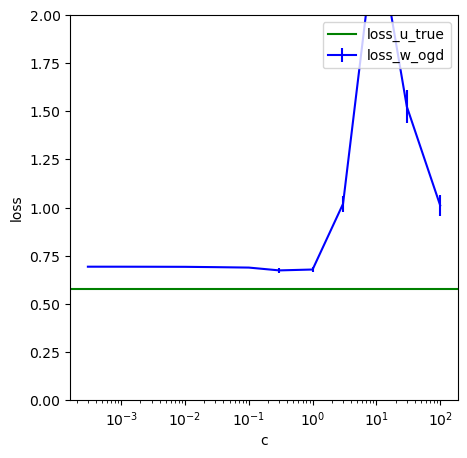

In [4]:
# parameters 
num_feats = 100
nsamples_train = 100
nsamples_test = 500

u_true = 2*np.ones((1,num_feats))/np.sqrt(num_feats)
w_norm_threshold = 20

num_runs = 5 
c_list = [0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
loss_w_ogd_array = np.zeros((len(c_list), num_runs))
loss_u_true_array = np.zeros((len(c_list), num_runs))
for cidx, c in enumerate(c_list):
    # print(f"\n-> idx = {cidx}, c = {c}")
    for ridx in range(num_runs):
        X_train, y_train = generate_data(nsamples_train, num_feats, u_true, seed=10000+100*cidx+ridx) 
        X_test, y_test = generate_data(nsamples_test, num_feats, u_true, seed=20000+100*cidx+ridx)

        step_size = c/np.sqrt(nsamples_train)
        w_ogd = train_ogd(X_train, y_train, step_size, w_norm_threshold)
        loss_w_ogd = compute_loss(X_test, y_test, w_ogd)
        loss_u_true = compute_loss(X_test, y_test, u_true)
        loss_w_ogd_array[cidx, ridx] = loss_w_ogd
        loss_u_true_array[cidx, ridx] = loss_u_true
        
        # print(f"loss_w_ogd = {loss_w_ogd:0.5f}")
        # print(f"loss_u_true = {loss_u_true:0.5f}")
    

# plot
loss_w_ogd_mean = np.mean(loss_w_ogd_array, axis=1)
loss_u_true_mean = np.mean(loss_u_true_array)
loss_w_ogd_std = np.std(loss_w_ogd_array, axis=1)
# loss_u_true_std = np.std(loss_u_true_array, axis=1)

# print(loss_w_ogd_mean)
# print(loss_w_ogd_std)
# print(loss_u_true_mean)

best_cidx = np.argmin(loss_w_ogd_mean)
best_cval = c_list[best_cidx]
print(f"Best c = {best_cval:0.5f}, step_size = {best_cval/np.sqrt(nsamples_train):0.5f}")
  
# plot
fig, axes = plt.subplots(1, 1, figsize=(5,5))
axes = [axes]
axes[0].errorbar(c_list, loss_w_ogd_mean, yerr=loss_w_ogd_std, color='blue', label='loss_w_ogd')
axes[0].axhline(y=loss_u_true_mean, color='green', linestyle='-', label='loss_u_true')
# axes[0].axvline(best_cval, linestyle='--', color="k", label="Best c")
axes[0].set_xscale('log')
axes[0].set_xlabel('c')
axes[0].set_ylim(0, 2)
axes[0].set_ylabel('loss')
axes[0].legend(loc="upper right")
plt.show()

Best c = 0.10000, step_size = 0.01000


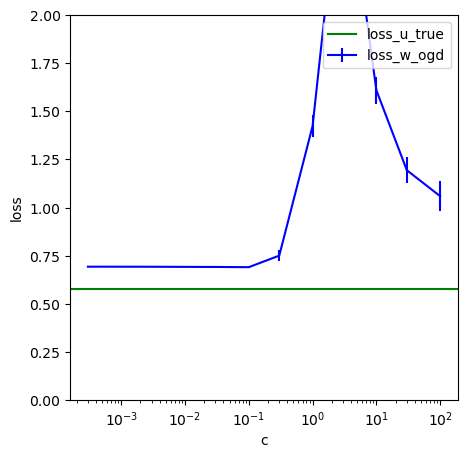

In [5]:
# parameters 
num_feats = 1000
nsamples_train = 100
nsamples_test = 500

u_true = 2*np.ones((1,num_feats))/np.sqrt(num_feats)
w_norm_threshold = 20

num_runs = 5 
c_list = [0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
loss_w_ogd_array = np.zeros((len(c_list), num_runs))
loss_u_true_array = np.zeros((len(c_list), num_runs))
for cidx, c in enumerate(c_list):
    # print(f"\n-> idx = {cidx}, c = {c}")
    for ridx in range(num_runs):
        X_train, y_train = generate_data(nsamples_train, num_feats, u_true, seed=10000+100*cidx+ridx) 
        X_test, y_test = generate_data(nsamples_test, num_feats, u_true, seed=20000+100*cidx+ridx)

        step_size = c/np.sqrt(nsamples_train)
        w_ogd = train_ogd(X_train, y_train, step_size, w_norm_threshold)
        loss_w_ogd = compute_loss(X_test, y_test, w_ogd)
        loss_u_true = compute_loss(X_test, y_test, u_true)
        loss_w_ogd_array[cidx, ridx] = loss_w_ogd
        loss_u_true_array[cidx, ridx] = loss_u_true
        
        # print(f"loss_w_ogd = {loss_w_ogd:0.5f}")
        # print(f"loss_u_true = {loss_u_true:0.5f}")
    

# plot
loss_w_ogd_mean = np.mean(loss_w_ogd_array, axis=1)
loss_u_true_mean = np.mean(loss_u_true_array)
loss_w_ogd_std = np.std(loss_w_ogd_array, axis=1)
# loss_u_true_std = np.std(loss_u_true_array, axis=1)

# print(loss_w_ogd_mean)
# print(loss_w_ogd_std)
# print(loss_u_true_mean)

best_cidx = np.argmin(loss_w_ogd_mean)
best_cval = c_list[best_cidx]
print(f"Best c = {best_cval:0.5f}, step_size = {best_cval/np.sqrt(nsamples_train):0.5f}")
  
# plot
fig, axes = plt.subplots(1, 1, figsize=(5,5))
axes = [axes]
axes[0].errorbar(c_list, loss_w_ogd_mean, yerr=loss_w_ogd_std, color='blue', label='loss_w_ogd')
axes[0].axhline(y=loss_u_true_mean, color='green', linestyle='-', label='loss_u_true')
# axes[0].axvline(best_cval, linestyle='--', color="k", label="Best c")
axes[0].set_xscale('log')
axes[0].set_xlabel('c')
axes[0].set_ylim(0, 2)
axes[0].set_ylabel('loss')
axes[0].legend(loc="upper right")
plt.show()

The optimal choice of $c$ are $c=0.3$ and $0.1$ when $d = 100$ and $d=1000$ respectively. They gets smaller compared to when $d=10$. The results follow the theoretical analysis since optimal $\eta = \frac{20}{\sqrt{Td}}$ decreases when $d$ increases.   